# Advanced topic: Solving the two-layer grey gas model analytically with sympy

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________

## 1. Introducing symbolic computation with sympy
____________

These notes elaborate on material in the [lecture on elementary greenhouse models](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/elementary-greenhouse.html), demonstrating use of a computer algebra system to make precise calculations.

### Symbolic math with the sympy package

The two-layer grey gas model is simple enough that we can work out all the details algebraically. There are three temperatures to keep track of $(T_s, T_0, T_1)$, so we will have 3x3 matrix equations.

We all know how to work these things out with pencil and paper. But it can be tedious and error-prone. 

Symbolic math software lets us use the computer to automate a lot of tedious algebra.

The [sympy](http://www.sympy.org/en/index.html) package is a powerful open-source symbolic math library that is well-integrated into the scientific Python ecosystem. 

### Getting started with sympy

In [1]:
import sympy
#  Allow sympy to produce nice looking equations as output
sympy.init_printing()
#  Define some symbols for mathematical quantities
#  Assume all quantities are positive (which will help simplify some expressions)
epsilon, T_e, T_s, T_0, T_1, sigma = \
    sympy.symbols('epsilon, T_e, T_s, T_0, T_1, sigma', positive=True)
#  So far we have just defined some symbols, e.g.
T_s

In [2]:
#  We have hard-coded the assumption that the temperature is positive
sympy.ask(T_s>0)

True

____________

## 2. Coding up the 2-layer grey gas model in sympy
____________

### Longwave emissions

Let's denote the emissions from each layer as
\begin{align}
E_s &= \sigma T_s^4 \\
E_0 &= \epsilon \sigma T_0^4 \\
E_1 &= \epsilon \sigma T_1^4 
\end{align}

recognizing that $E_0$ and $E_1$ contribute to **both** the upwelling and downwelling beams.

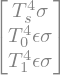

In [3]:
#  Define these operations as sympy symbols 
#  And display as a column vector:
E_s = sigma*T_s**4
E_0 = epsilon*sigma*T_0**4
E_1 = epsilon*sigma*T_1**4
E = sympy.Matrix([E_s, E_0, E_1])
E

### Shortwave radiation

Since we have assumed the atmosphere is transparent to shortwave, the incident beam $Q$ passes unchanged from the top to the surface, where a fraction $\alpha$ is reflected upward out to space.

In [4]:
#  Define some new symbols for shortwave radiation
Q, alpha = sympy.symbols('Q, alpha', positive=True)
#  Create a dictionary to hold our numerical values
tuned = {}
tuned[Q] = 341.3  #  global mean insolation in W/m2
tuned[alpha] = 101.9/Q.subs(tuned)  #  observed planetary albedo
tuned[sigma] = 5.67E-8  #  Stefan-Boltzmann constant in W/m2/K4
tuned
#  Numerical value for emission temperature
#T_e.subs(tuned)

### Tracing the upwelling beam of longwave radiation

Let $U$ be the upwelling flux of longwave radiation. 

The upward flux **from the surface to layer 0** is

$$ U_0 = E_s $$

(just the emission from the suface).

In [5]:
U_0 = E_s
U_0

Following this beam upward, we can write the upward flux from layer 0 to layer 1 as the sum of the transmitted component that originated below layer 0 and the new emissions from layer 0:

$$ U_1 = (1-\epsilon) U_0 + E_0 $$

In [6]:
U_1 = (1-epsilon)*U_0 + E_0
U_1

Continuing to follow the same beam, the upwelling flux above layer 1 is
$$ U_2 = (1-\epsilon) U_1 + E_1 $$

In [7]:
U_2 = (1-epsilon) * U_1 + E_1

Since there is no more atmosphere above layer 1, this upwelling flux is our Outgoing Longwave Radiation for this model:

$$ OLR = U_2 $$

In [8]:
U_2

The three terms in the above expression represent the **contributions to the total OLR that originate from each of the three levels**. 

Let's code this up explicitly for future reference:

In [9]:
#  Define the contributions to OLR originating from each level
OLR_s = (1-epsilon)**2 *sigma*T_s**4
OLR_0 = epsilon*(1-epsilon)*sigma*T_0**4
OLR_1 = epsilon*sigma*T_1**4

OLR = OLR_s + OLR_0 + OLR_1

print( 'The expression for OLR is')
OLR

The expression for OLR is


### Downwelling beam

Let $D$ be the downwelling longwave beam. Since there is no longwave radiation coming in from space, we begin with 

In [10]:
fromspace = 0
D_2 = fromspace

Between layer 1 and layer 0 the beam contains emissions from layer 1:

$$ D_1 = (1-\epsilon)D_2 + E_1 = E_1 $$

In [11]:
D_1 = (1-epsilon)*D_2 + E_1
D_1

Finally between layer 0 and the surface the beam contains a transmitted component and the emissions from layer 0:

$$ D_0 = (1-\epsilon) D_1 + E_0 = \epsilon(1-\epsilon) \sigma T_1^4 + \epsilon \sigma T_0^4$$

In [12]:
D_0 = (1-epsilon)*D_1 + E_0
D_0

This $D_0$ is what we call the **back radiation**, i.e. the longwave radiation from the atmosphere to the surface.

____________
## 3. Tuning the grey gas model to observations
____________

In building our new model we have introduced exactly one parameter, the absorptivity $\epsilon$. We need to choose a value for $\epsilon$.

We will tune our model so that it **reproduces the observed global mean OLR** given **observed global mean temperatures**.

To get appropriate temperatures for $T_s, T_0, T_1$, revisit the global, annual mean lapse rate plot from NCEP Reanalysis data we first encountered in the [Radiation notes](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/radiation.html).

### Temperatures

First, we set 
$$T_s = 288 \text{ K}  $$

From the lapse rate plot, an average temperature for the layer between 1000 and 500 hPa is 

$$ T_0 = 275 \text{ K}$$

Defining an average temperature for the layer between 500 and 0 hPa is more ambiguous because of the lapse rate reversal at the tropopause. We will choose

$$ T_1 = 230 \text{ K}$$

From the graph, this is approximately the observed global mean temperature at 275 hPa or about 10 km.

In [13]:
#  add to our dictionary of values:
tuned[T_s] = 288.
tuned[T_0] = 275.
tuned[T_1] = 230.
tuned

### OLR

From the [observed global energy budget](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/models-budgets-fun.html#the-observed-global-energy-budget) we set 

$$ OLR = 238.5 \text{ W m}^{-2} $$

### Solving for $\epsilon$

We wrote down the expression for OLR as a function of temperatures and absorptivity in our model above. 

We just need to equate this to the observed value and solve a **quadratic equation** for $\epsilon$.

This is where the real power of the symbolic math toolkit comes in. 

Subsitute in the numerical values we are interested in:

In [14]:
# the .subs() method for a sympy symbol means
#  substitute values in the expression using the supplied dictionary
#  Here we use observed values of Ts, T0, T1 
OLR2 = OLR.subs(tuned)
OLR2

We have a quadratic equation for $\epsilon$.

Now use the `sympy.solve` function to solve the quadratic:

In [15]:
#  The sympy.solve method takes an expression equal to zero
#  So in this case we subtract the tuned value of OLR from our expression
eps_solution = sympy.solve(OLR2 - 238.5, epsilon)
eps_solution

There are two roots, but the second one is unphysical since we must have $0 < \epsilon < 1$.

Just for fun, here is a simple of example of *filtering a list* using powerful Python *list comprehension* syntax:

In [16]:
# Give me only the roots that are between zero and 1!
list_result = [eps for eps in eps_solution if 0<eps<1]
print( list_result)
# The result is a list with a single element.
#  We need to slice the list to get just the number:
eps_tuned = list_result[0]
print( eps_tuned)

[0.586041150248834]
0.586041150248834


We conclude that our tuned value is (to within 3 decimal places):

$$ \epsilon = 0.586 $$

This is the absorptivity that guarantees that our model reproduces the observed OLR given the observed tempertures.

In [17]:
tuned[epsilon] = eps_tuned
tuned

____________
## 4. Level of emission
____________

Even in this very simple greenhouse model, there is **no single level** at which the OLR is generated.

The three terms in our formula for OLR tell us the contributions from each level.

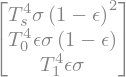

In [18]:
OLRterms = sympy.Matrix([OLR_s, OLR_0, OLR_1])
OLRterms

Now evaluate these expressions for our tuned temperature and absorptivity:

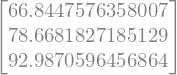

In [19]:
OLRtuned = OLRterms.subs(tuned)
OLRtuned

So we are getting about 67 W m$^{-2}$ from the surface, 79 W m$^{-2}$ from layer 0, and 93 W m$^{-2}$ from the top layer.

In terms of fractional contributions to the total OLR, we have (limiting the output to two decimal places):

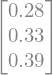

In [20]:
sympy.N(OLRtuned / 238.5, 2)

Notice that the largest single contribution is coming from the top layer. This is in spite of the fact that the emissions from this layer are weak, because it is so cold.

Comparing to observations, the actual contribution to OLR from the surface is about 22 W m$^{-2}$ (or about 9% of the total), not 67 W m$^{-2}$. So we certainly don't have all the details worked out yet!

As we will see later, to really understand what sets that observed 22 W m$^{-2}$, we will need to start thinking about the spectral dependence of the longwave absorptivity.

____________
## 5. Radiative forcing in the 2-layer grey gas model
____________

Adding some extra greenhouse absorbers will mean that a greater fraction of incident longwave radiation is absorbed in each layer.

Thus **$\epsilon$ must increase** as we add greenhouse gases.

Suppose we have $\epsilon$ initially, and the absorptivity increases to $\epsilon_2 = \epsilon + \delta_\epsilon$.

Suppose further that this increase happens **abruptly** so that there is no time for the temperatures to respond to this change. **We hold the temperatures fixed** in the column and ask how the radiative fluxes change.

**Do you expect the OLR to increase or decrease?**

Let's use our two-layer leaky greenhouse model to investigate the answer.

The components of the OLR before the perturbation are

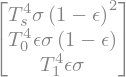

In [21]:
OLRterms

After the perturbation we have

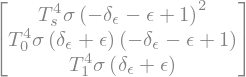

In [22]:
delta_epsilon = sympy.symbols('delta_epsilon')
OLRterms_pert = OLRterms.subs(epsilon, epsilon+delta_epsilon)
OLRterms_pert

Let's take the difference

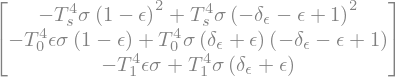

In [23]:
deltaOLR = OLRterms_pert - OLRterms
deltaOLR

To make things simpler, we will neglect the terms in $\delta_\epsilon^2$. This is perfectly reasonably because we are dealing with **small perturbations** where $\delta_\epsilon << \epsilon$.

Telling `sympy` to set the quadratic terms to zero gives us

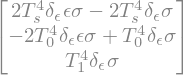

In [24]:
deltaOLR_linear = sympy.expand(deltaOLR).subs(delta_epsilon**2, 0)
deltaOLR_linear

Recall that the three terms are the contributions to the OLR from the three different levels. In this case, the **changes** in those contributions after adding more absorbers.

Now let's divide through by $\delta_\epsilon$ to get the normalized change in OLR per unit change in absorptivity:

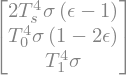

In [25]:
deltaOLR_per_deltaepsilon = \
    sympy.simplify(deltaOLR_linear / delta_epsilon)
deltaOLR_per_deltaepsilon

Now look at the **sign** of each term. Recall that $0 < \epsilon < 1$. **Which terms in the OLR go up and which go down?**

**THIS IS VERY IMPORTANT, SO STOP AND THINK ABOUT IT.**

The contribution from the **surface** must **decrease**, while the contribution from the **top layer** must **increase**.

**When we add absorbers, the average level of emission goes up!**

### "Radiative forcing" is the change in radiative flux at TOA after adding absorbers

In this model, only the longwave flux can change, so we define the radiative forcing as

$$ R = - \delta OLR $$

(with the minus sign so that $R$ is positive when the climate system is gaining extra energy).

We just worked out that whenever we add some extra absorbers, the emissions to space (on average) will originate from higher levels in the atmosphere. 

What does this mean for OLR? Will it increase or decrease?

To get the answer, we just have to sum up the three contributions we wrote above:

In [26]:
R_per_deltaepsilon = -sum(deltaOLR_per_deltaepsilon)
R_per_deltaepsilon

Is this a positive or negative number? The key point is this:

**It depends on the temperatures, i.e. on the lapse rate.**

### Greenhouse effect for an isothermal atmosphere

Stop and think about this question:

If the **surface and atmosphere are all at the same temperature**, does the OLR go up or down when $\epsilon$ increases (i.e. we add more absorbers)?

Understanding this question is key to understanding how the greenhouse effect works.

#### Let's solve the isothermal case

We will just set $T_s = T_0 = T_1$ in the above expression for the radiative forcing.

In [27]:
R_per_deltaepsilon.subs([(T_0, T_s), (T_1, T_s)])

which then simplifies to

In [28]:
sympy.simplify(R_per_deltaepsilon.subs([(T_0, T_s), (T_1, T_s)]))

#### The answer is zero

For an isothermal atmosphere, there is **no change** in OLR when we add extra greenhouse absorbers. Hence, no radiative forcing and no greenhouse effect.

Why?

The level of emission still must go up. But since the temperature at the upper level is the **same** as everywhere else, the emissions are exactly the same.

### The radiative forcing (change in OLR) depends on the lapse rate!

For a more realistic example of radiative forcing due to an increase in greenhouse absorbers, we can substitute in our tuned values for temperature and $\epsilon$. 

We'll express the answer in W m$^{-2}$ for a 2% increase in $\epsilon$.

In [29]:
delta_epsilon = 0.02 * epsilon
delta_epsilon

The three components of the OLR change are

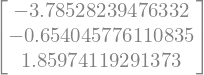

In [30]:
(deltaOLR_per_deltaepsilon * delta_epsilon).subs(tuned)

And the net radiative forcing is

In [31]:
(R_per_deltaepsilon*delta_epsilon).subs(tuned)

So in our example, **the OLR decreases by 2.6 W m$^{-2}$**, or equivalently, the radiative forcing is +2.6 W m$^{-2}$.

What we have just calculated is this:

*Given the observed lapse rates, a small increase in absorbers will cause a small decrease in OLR.*

The greenhouse effect thus gets stronger, and energy will begin to accumulate in the system -- which will eventually cause temperatures to increase as the system adjusts to a new equilibrium.

____________
## 6. Radiative equilibrium in the 2-layer grey gas model
____________

In the previous section we:

- made no assumptions about the processes that actually set the temperatures. 
- used the model to calculate radiative fluxes, **given observed temperatures**. 
- stressed the importance of knowing the lapse rates in order to know how an increase in emission level would affect the OLR, and thus determine the radiative forcing.

A key question in climate dynamics is therefore this:

**What sets the lapse rate?**

It turns out that lots of different physical processes contribute to setting the lapse rate. 

Understanding how these processes acts together and how they change as the climate changes is one of the key reasons for which we need more complex climate models.

For now, we will use our prototype greenhouse model to do the most basic lapse rate calculation: the **radiative equilibrium temperature**.

We assume that

- the only exchange of energy between layers is longwave radiation
- equilibrium is achieved when the **net radiative flux convergence** in each layer is zero.

### Compute the radiative flux convergence

First, the **net upwelling flux** is just the difference between flux up and flux down:

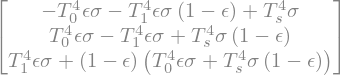

In [32]:
#  Upwelling and downwelling beams as matrices
U = sympy.Matrix([U_0, U_1, U_2])
D = sympy.Matrix([D_0, D_1, D_2])
# Net flux, positive up
F = U-D
F

####  Net absorption is the flux convergence in each layer

(difference between what's coming in the bottom and what's going out the top of each layer)

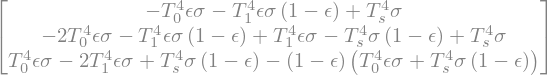

In [33]:
# define a vector of absorbed radiation -- same size as emissions
A = E.copy()

#  absorbed radiation at surface
A[0] = F[0]
# Compute the convergence
for n in range(2):
    A[n+1] = -(F[n+1]-F[n])

A

#### Radiative equilibrium means net absorption is ZERO in the atmosphere

The only other heat source is the **shortwave heating** at the **surface**.

In matrix form, here is the system of equations to be solved:

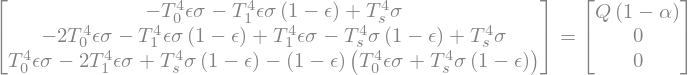

In [34]:
radeq = sympy.Equality(A, sympy.Matrix([(1-alpha)*Q, 0, 0]))
radeq

Just as we did for the 1-layer model, it is helpful to rewrite this system using the definition of the **emission temperture** $T_e$

$$ (1-\alpha) Q = \sigma T_e^4 $$

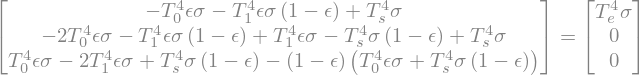

In [35]:
radeq2 = radeq.subs([((1-alpha)*Q, sigma*T_e**4)])
radeq2

In this form we can see that we actually have a **linear system** of equations for a set of variables $T_s^4, T_0^4, T_1^4$.

We can solve this matrix problem to get these as functions of $T_e^4$.

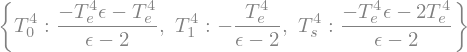

In [36]:
# Solve for radiative equilibrium 
fourthpower = sympy.solve(radeq2, [T_s**4, T_1**4, T_0**4])
fourthpower

This produces a dictionary of solutions for the fourth power of the temperatures!

A little manipulation gets us the solutions for temperatures that we want:

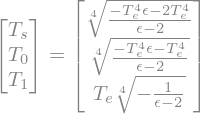

In [37]:
# need the symbolic fourth root operation
from sympy.simplify.simplify import nthroot

fourthpower_list = [fourthpower[key] for key in [T_s**4, T_0**4, T_1**4]]
solution = sympy.Matrix([nthroot(item,4) for item in fourthpower_list])
#  Display result as matrix equation!
T = sympy.Matrix([T_s, T_0, T_1])
sympy.Equality(T, solution)

In more familiar notation, the radiative equilibrium solution is thus

\begin{align} 
T_s &= T_e \left( \frac{2+\epsilon}{2-\epsilon} \right)^{1/4} \\
T_0 &= T_e \left( \frac{1+\epsilon}{2-\epsilon} \right)^{1/4} \\
T_1 &= T_e \left( \frac{ 1}{2 - \epsilon} \right)^{1/4}
\end{align}

Plugging in the tuned value $\epsilon = 0.586$ gives

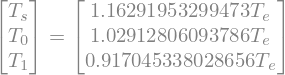

In [38]:
Tsolution = solution.subs(tuned)
#  Display result as matrix equation!
sympy.Equality(T, Tsolution)

Now we just need to know the Earth's emission temperature $T_e$!

(Which we already know is about 255 K)

In [39]:
# Here's how to calculate T_e from the observed values
sympy.solve(((1-alpha)*Q - sigma*T_e**4).subs(tuned), T_e)

In [40]:
# Need to unpack the list
Te_value = sympy.solve(((1-alpha)*Q - sigma*T_e**4).subs(tuned), T_e)[0]
Te_value

#### Now we finally get our solution for radiative equilibrium

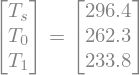

In [41]:
#  Output 4 significant digits
Trad = sympy.N(Tsolution.subs([(T_e, Te_value)]), 4)
sympy.Equality(T, Trad)

Compare these to the values we derived from the **observed lapse rates**:

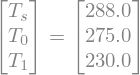

In [42]:
sympy.Equality(T, T.subs(tuned))

The **radiative equilibrium** solution is substantially **warmer at the surface** and **colder in the lower troposphere** than reality.

This is a very general feature of radiative equilibrium, and we will see it again very soon in this course.

____________
## 7. Summary
____________

## Key physical lessons

- Putting a **layer of longwave absorbers** above the surface keeps the **surface substantially warmer**, because of the **backradiation** from the atmosphere (greenhouse effect).
- The **grey gas** model assumes that each layer absorbs and emits a fraction $\epsilon$ of its blackbody value, independent of wavelength.

- With **incomplete absorption** ($\epsilon < 1$), there are contributions to the OLR from every level and the surface (there is no single **level of emission**)
- Adding more absorbers means that **contributions to the OLR** from **upper levels** go **up**, while contributions from the surface go **down**.
- This upward shift in the weighting of different levels is what we mean when we say the **level of emission goes up**.

- The **radiative forcing** caused by an increase in absorbers **depends on the lapse rate**.
- For an **isothermal atmosphere** the radiative forcing is zero and there is **no greenhouse effect**
- The radiative forcing is positive for our atmosphere **because tropospheric temperatures tends to decrease with height**.
- Pure **radiative equilibrium** produces a **warm surface** and **cold lower troposphere**.
- This is unrealistic, and suggests that crucial heat transfer mechanisms are missing from our model.

### And on the Python side...

Did we need `sympy` to work all this out? No, of course not. We could have solved the 3x3 matrix problems by hand. But computer algebra can be very useful and save you a lot of time and error, so it's good to invest some effort into learning how to use it. 

Hopefully these notes provide a useful starting point.

### A follow-up assignment

You are now ready to tackle a follow-up assignment where you are asked to extend this grey-gas analysis to many layers. 

For more than a few layers, the analytical approach we used here is no longer very useful. You will code up a numerical solution to calculate OLR given temperatures and absorptivity, and look at how the lapse rate determines radiative forcing for a given increase in absorptivity.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/climlab/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________